In [ ]:
!pip install geopandas
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812365 sha256=8863220c689c265e42c801832be885b7f55a3c146d8008cd5f32354dc7ca7cfa
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


In [ ]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import round, col, sum, max, min
from pyspark.sql.types import *

import zipfile
import io
from urllib.parse import quote
import matplotlib.pyplot as plt
import geopandas as gpd
import requests
import time
import json

In [ ]:
API_KEY = ''

In [ ]:

states = {
    'AC': 'Acre',
    'AL': 'Alagoas',
    'AP': 'Amapá',
    'AM': 'Amazonas',
    'BA': 'Bahia',
    'CE': 'Ceará',
    'DF': 'Distrito Federal',
    'ES': 'Espírito Santo',
    'GO': 'Goiás',
    'MA': 'Maranhão',
    'MS': 'Mato Grosso do Sul',
    'MT': 'Mato Grosso',
    'MG': 'Minas Gerais',
    'PA': 'Pará',
    'PB': 'Paraíba',
    'PE': 'Pernambuco',
    'PI': 'Piauí',
    'PR': 'Paraná',
    'RO': 'Rondônia',
    'RR': 'Roraima',
    'RJ': 'Rio de Janeiro',
    'RS': 'Rio Grande do Sul',
    'RN': 'Rio Grande do Norte',
    'SC': 'Santa Catarina',
    'SE': 'Sergipe',
    'SP': 'São Paulo',
    'TO': 'Tocantins'
}

In [ ]:
states_with_cities = []
for key in states.keys():
    states_with_cities.append(requests.get(f'https://servicodados.ibge.gov.br/api/v1/localidades/estados/{key}/municipios').json())
    time.sleep(0.5)

In [ ]:
prep_states_df = []
for acr in states.keys():
    prep_states_df.append({'UF': acr, 'name': states[acr]})

In [ ]:
states_with_cities

[[{'id': 1200013,
   'nome': 'Acrelândia',
   'microrregiao': {'id': 12004,
    'nome': 'Rio Branco',
    'mesorregiao': {'id': 1202,
     'nome': 'Vale do Acre',
     'UF': {'id': 12,
      'sigla': 'AC',
      'nome': 'Acre',
      'regiao': {'id': 1, 'sigla': 'N', 'nome': 'Norte'}}}},
   'regiao-imediata': {'id': 120001,
    'nome': 'Rio Branco',
    'regiao-intermediaria': {'id': 1201,
     'nome': 'Rio Branco',
     'UF': {'id': 12,
      'sigla': 'AC',
      'nome': 'Acre',
      'regiao': {'id': 1, 'sigla': 'N', 'nome': 'Norte'}}}}},
  {'id': 1200054,
   'nome': 'Assis Brasil',
   'microrregiao': {'id': 12005,
    'nome': 'Brasiléia',
    'mesorregiao': {'id': 1202,
     'nome': 'Vale do Acre',
     'UF': {'id': 12,
      'sigla': 'AC',
      'nome': 'Acre',
      'regiao': {'id': 1, 'sigla': 'N', 'nome': 'Norte'}}}},
   'regiao-imediata': {'id': 120002,
    'nome': 'Brasiléia',
    'regiao-intermediaria': {'id': 1201,
     'nome': 'Rio Branco',
     'UF': {'id': 12,
      'sigl

In [ ]:
filtered_cities = []

for state in states_with_cities:
    for city in state:
        filtered_city = {}
        filtered_city['id'] = city['id']
        filtered_city['name'] = city ['nome']
        filtered_city['UF'] = city['microrregiao']['mesorregiao']['UF']['sigla']
        filtered_city['regiao'] = city['microrregiao']['mesorregiao']['UF']['regiao']['nome']
        filtered_cities.append(filtered_city)

print(filtered_cities)



[{'id': 1200013, 'name': 'Acrelândia', 'UF': 'AC', 'regiao': 'Norte'}, {'id': 1200054, 'name': 'Assis Brasil', 'UF': 'AC', 'regiao': 'Norte'}, {'id': 1200104, 'name': 'Brasiléia', 'UF': 'AC', 'regiao': 'Norte'}, {'id': 1200138, 'name': 'Bujari', 'UF': 'AC', 'regiao': 'Norte'}, {'id': 1200179, 'name': 'Capixaba', 'UF': 'AC', 'regiao': 'Norte'}, {'id': 1200203, 'name': 'Cruzeiro do Sul', 'UF': 'AC', 'regiao': 'Norte'}, {'id': 1200252, 'name': 'Epitaciolândia', 'UF': 'AC', 'regiao': 'Norte'}, {'id': 1200302, 'name': 'Feijó', 'UF': 'AC', 'regiao': 'Norte'}, {'id': 1200328, 'name': 'Jordão', 'UF': 'AC', 'regiao': 'Norte'}, {'id': 1200336, 'name': 'Mâncio Lima', 'UF': 'AC', 'regiao': 'Norte'}, {'id': 1200344, 'name': 'Manoel Urbano', 'UF': 'AC', 'regiao': 'Norte'}, {'id': 1200351, 'name': 'Marechal Thaumaturgo', 'UF': 'AC', 'regiao': 'Norte'}, {'id': 1200385, 'name': 'Plácido de Castro', 'UF': 'AC', 'regiao': 'Norte'}, {'id': 1200393, 'name': 'Porto Walter', 'UF': 'AC', 'regiao': 'Norte'}, {

In [ ]:
spark = SparkSession.builder.appName('airPollution').getOrCreate()


In [ ]:
ibge_df = spark.createDataFrame(filtered_cities)
states_df = spark.createDataFrame(prep_states_df)

In [ ]:
ibge_df.show(10)

+---+-------+---------------+------+
| UF|     id|           name|regiao|
+---+-------+---------------+------+
| AC|1200013|     Acrelândia| Norte|
| AC|1200054|   Assis Brasil| Norte|
| AC|1200104|      Brasiléia| Norte|
| AC|1200138|         Bujari| Norte|
| AC|1200179|       Capixaba| Norte|
| AC|1200203|Cruzeiro do Sul| Norte|
| AC|1200252| Epitaciolândia| Norte|
| AC|1200302|          Feijó| Norte|
| AC|1200328|         Jordão| Norte|
| AC|1200336|    Mâncio Lima| Norte|
+---+-------+---------------+------+
only showing top 10 rows



In [ ]:
states_df.show()

+---+------------------+
| UF|              name|
+---+------------------+
| AC|              Acre|
| AL|           Alagoas|
| AP|             Amapá|
| AM|          Amazonas|
| BA|             Bahia|
| CE|             Ceará|
| DF|  Distrito Federal|
| ES|    Espírito Santo|
| GO|             Goiás|
| MA|          Maranhão|
| MS|Mato Grosso do Sul|
| MT|       Mato Grosso|
| MG|      Minas Gerais|
| PA|              Pará|
| PB|           Paraíba|
| PE|        Pernambuco|
| PI|             Piauí|
| PR|            Paraná|
| RO|          Rondônia|
| RR|           Roraima|
+---+------------------+
only showing top 20 rows



In [ ]:
for city in filtered_cities:
    print(city['name'])

A saída de streaming foi truncada nas últimas 5000 linhas.
Sebastião Laranjeiras
Senhor do Bonfim
Serra do Ramalho
Sento Sé
Serra Dourada
Serra Preta
Serrinha
Serrolândia
Simões Filho
Sítio do Mato
Sítio do Quinto
Sobradinho
Souto Soares
Tabocas do Brejo Velho
Tanhaçu
Tanque Novo
Tanquinho
Taperoá
Tapiramutá
Teixeira de Freitas
Teodoro Sampaio
Teofilândia
Teolândia
Terra Nova
Tremedal
Tucano
Uauá
Ubaíra
Ubaitaba
Ubatã
Uibaí
Umburanas
Una
Urandi
Uruçuca
Utinga
Valença
Valente
Várzea da Roça
Várzea do Poço
Várzea Nova
Varzedo
Vera Cruz
Vereda
Vitória da Conquista
Wagner
Wanderley
Wenceslau Guimarães
Xique-Xique
Abaiara
Acarape
Acaraú
Acopiara
Aiuaba
Alcântaras
Altaneira
Alto Santo
Amontada
Antonina do Norte
Apuiarés
Aquiraz
Aracati
Aracoiaba
Ararendá
Araripe
Aratuba
Arneiroz
Assaré
Aurora
Baixio
Banabuiú
Barbalha
Barreira
Barro
Barroquinha
Baturité
Beberibe
Bela Cruz
Boa Viagem
Brejo Santo
Camocim
Campos Sales
Canindé
Capistrano
Caridade
Cariré
Caririaçu
Cariús
Carnaubal
Cascavel
Catarin

In [ ]:
city_url = []
#converting cities name to percentage-encoding
for city in filtered_cities:
    city_url.append({quote(city['name']): states[city['UF']]})

In [ ]:
len(city_url)

5570

In [ ]:
found_cities = []
for city in city_url:
    key = next(iter(city))
    raw_data = requests.get(f'http://api.openweathermap.org/geo/1.0/direct?q={key}&limit=5&appid={API_KEY}').json()
    print(raw_data)
    for result in raw_data:
        if result['country'] == 'BR' and result['state'] == city[key]:
            found_cities.append(result)
            break
    time.sleep(0.5)

A saída de streaming foi truncada nas últimas 5000 linhas.
[{'name': 'Sebastião Laranjeiras', 'lat': -14.5700161, 'lon': -42.9442517, 'country': 'BR', 'state': 'Bahia'}, {'name': 'Sebastião Laranjeiras', 'lat': -14.6365156, 'lon': -43.0380865344833, 'country': 'BR', 'state': 'Bahia'}]
[{'name': 'Senhor do Bonfim', 'local_names': {'pt': 'Senhor do Bonfim', 'en': 'Senhor do Bonfim', 'ru': 'Сеньор-ду-Бонфин'}, 'lat': -10.4602509, 'lon': -40.189151, 'country': 'BR', 'state': 'Bahia'}, {'name': 'Senhor do Bonfim', 'lat': -14.667716, 'lon': -40.4789868, 'country': 'BR', 'state': 'Bahia'}, {'name': 'Senhor do Bonfim', 'lat': -19.8274436, 'lon': -43.0925256, 'country': 'BR', 'state': 'Minas Gerais'}, {'name': 'Senhor do Bonfim', 'lat': -13.4646722, 'lon': -40.9135151, 'country': 'BR', 'state': 'Bahia'}]
[{'name': 'Serra do Ramalho', 'lat': -13.5442363, 'lon': -43.5773151, 'country': 'BR', 'state': 'Bahia'}]
[{'name': 'Sento Sé', 'lat': -9.7406436, 'lon': -41.8830056, 'country': 'BR', 'state': 

In [ ]:
with open("cities.txt", "w") as fp:
  fp.write(repr(found_cities))

In [ ]:
cities_lat_lon = spark.createDataFrame(found_cities)
null_counts = cities_lat_lon.select([sum(col(c).isNull().cast('int')).alias(c) for c in cities_lat_lon.columns])
null_counts.show()

+-------+---+---+----+-----+-----------+
|country|lat|lon|name|state|local_names|
+-------+---+---+----+-----+-----------+
|      0|  0|  0|   0|    0|       4940|
+-------+---+---+----+-----+-----------+



In [ ]:
# Wont be a important value
cities_lat_lon_df = cities_lat_lon.drop('local_names')

In [ ]:
cities_lat_lon_df.show()

+-------+------------------+------------------+--------------------+-----+
|country|               lat|               lon|                name|state|
+-------+------------------+------------------+--------------------+-----+
|     BR|       -10.0759167|       -67.0526898|          Acrelândia| Acre|
|     BR|       -10.9409203|       -69.5672108|        Assis Brasil| Acre|
|     BR|       -11.0010413|       -68.7487894|           Brasiléia| Acre|
|     BR|        -9.8309656|       -67.9520886|              Bujari| Acre|
|     BR|       -10.5741345|       -67.6759719|            Capixaba| Acre|
|     BR|        -7.6307956|       -72.6703869|     Cruzeiro do Sul| Acre|
|     BR|       -11.0289439|       -68.7411519|      Epitaciolândia| Acre|
|     BR|        -8.1648652|       -70.3539579|               Feijó| Acre|
|     BR|        -9.1905396|       -71.9484803|              Jordão| Acre|
|     BR|        -7.6145911|        -72.905264|         Mâncio Lima| Acre|
|     BR|-9.3954282999999

In [ ]:
cities_lat_lon_df.dtypes

[('country', 'string'),
 ('lat', 'double'),
 ('lon', 'double'),
 ('name', 'string'),
 ('state', 'string')]

In [ ]:
cities_lat_lon_df = cities_lat_lon_df.withColumn("lat_rounded", round(cities_lat_lon_df.lat, 2))
cities_lat_lon_df = cities_lat_lon_df.withColumn("lon_rounded", round(cities_lat_lon_df.lon, 2))

cities_lat_lon_df.show()

+-------+------------------+------------------+--------------------+-----+-----------+-----------+
|country|               lat|               lon|                name|state|lat_rounded|lon_rounded|
+-------+------------------+------------------+--------------------+-----+-----------+-----------+
|     BR|       -10.0759167|       -67.0526898|          Acrelândia| Acre|     -10.08|     -67.05|
|     BR|       -10.9409203|       -69.5672108|        Assis Brasil| Acre|     -10.94|     -69.57|
|     BR|       -11.0010413|       -68.7487894|           Brasiléia| Acre|      -11.0|     -68.75|
|     BR|        -9.8309656|       -67.9520886|              Bujari| Acre|      -9.83|     -67.95|
|     BR|       -10.5741345|       -67.6759719|            Capixaba| Acre|     -10.57|     -67.68|
|     BR|        -7.6307956|       -72.6703869|     Cruzeiro do Sul| Acre|      -7.63|     -72.67|
|     BR|       -11.0289439|       -68.7411519|      Epitaciolândia| Acre|     -11.03|     -68.74|
|     BR| 

In [ ]:
null_counts = cities_lat_lon_df.select([sum(col(c).isNull().cast('int')).alias(c) for c in cities_lat_lon_df.columns])
null_counts.show()

+-------+---+---+----+-----+-----------+-----------+
|country|lat|lon|name|state|lat_rounded|lon_rounded|
+-------+---+---+----+-----+-----------+-----------+
|      0|  0|  0|   0|    0|          0|          0|
+-------+---+---+----+-----+-----------+-----------+



In [ ]:
ibge_df = ibge_df.withColumnRenamed('name', 'city')
states_df = states_df.withColumnRenamed('name', 'state')
cities_lat_lon_df = cities_lat_lon_df.withColumnRenamed('name', 'city')
ibge_states = ibge_df.join(states_df, 'UF', 'LEFT')
ibge_states_pos = ibge_states.join(cities_lat_lon_df, ['city', 'state'], 'right')

ibge_states_pos.show(10)

DataFrame[city: string, state: string, UF: string, id: bigint, regiao: string, country: string, lat: double, lon: double, lat_rounded: double, lon_rounded: double]

In [ ]:
lat_lon = ibge_states_pos.select('id', 'lat_rounded', 'lon_rounded')

In [ ]:
consult_dict = list(map(lambda row: row.asDict(), lat_lon.collect()))
consult_dict

[{'id': 2920304, 'lat_rounded': -14.39, 'lon_rounded': -41.88},
 {'id': 2924058, 'lat_rounded': -11.83, 'lon_rounded': -39.61},
 {'id': 2307106, 'lat_rounded': -7.58, 'lon_rounded': -39.28},
 {'id': 5201306, 'lat_rounded': -16.46, 'lon_rounded': -49.96},
 {'id': 5210000, 'lat_rounded': -16.36, 'lon_rounded': -49.5},
 {'id': 5214804, 'lat_rounded': -18.06, 'lon_rounded': -48.26},
 {'id': 2106300, 'lat_rounded': -3.39, 'lon_rounded': -42.21},
 {'id': 2107209, 'lat_rounded': -3.47, 'lon_rounded': -43.91},
 {'id': 3101300, 'lat_rounded': -22.17, 'lon_rounded': -44.64},
 {'id': 3110301, 'lat_rounded': -21.92, 'lon_rounded': -46.39},
 {'id': 3127073, 'lat_rounded': -16.12, 'lon_rounded': -42.53},
 {'id': 3131307, 'lat_rounded': -19.48, 'lon_rounded': -42.53},
 {'id': 3169356, 'lat_rounded': -18.21, 'lon_rounded': -45.25},
 {'id': 3170651, 'lat_rounded': -15.4, 'lon_rounded': -42.31},
 {'id': 1501725, 'lat_rounded': -3.31, 'lon_rounded': -52.54},
 {'id': 2503704, 'lat_rounded': -6.89, 'lon_ro

In [ ]:
air_quality = []

for item in consult_dict:
    city_air = requests.get(f"http://api.openweathermap.org/data/2.5/air_pollution?lat={item['lat_rounded']}&lon={item['lon_rounded']}&appid={API_KEY}").json()
    air_quality.append({'id': item['id'], 'aqi': city_air['list'][0]['main']['aqi'], 'co': float(city_air['list'][0]['components']['co']), 'no': float(city_air['list'][0]['components']['no']), \
        'no2': float(city_air['list'][0]['components']['no2']), 'o3': float(city_air['list'][0]['components']['o3']), 'so2': float(city_air['list'][0]['components']['so2']), 'pm2_5': float(city_air['list'][0]['components']['pm2_5']), \
        'pm10': float(city_air['list'][0]['components']['pm10']), 'nh3': float(city_air['list'][0]['components']['nh3'])})
    time.sleep(0.5)

air_quality

[{'id': 2920304,
  'aqi': 1,
  'co': 236.99,
  'no': 0.0,
  'no2': 1.15,
  'o3': 52.21,
  'so2': 0.22,
  'pm2_5': 0.67,
  'pm10': 1.24,
  'nh3': 0.74},
 {'id': 2924058,
  'aqi': 1,
  'co': 243.66,
  'no': 0.0,
  'no2': 3.3,
  'o3': 45.78,
  'so2': 2.8,
  'pm2_5': 2.29,
  'pm10': 5.77,
  'nh3': 1.08},
 {'id': 2307106,
  'aqi': 2,
  'co': 350.48,
  'no': 0.0,
  'no2': 0.63,
  'o3': 61.51,
  'so2': 0.15,
  'pm2_5': 3.18,
  'pm10': 5.18,
  'nh3': 0.78},
 {'id': 5201306,
  'aqi': 2,
  'co': 423.91,
  'no': 0.0,
  'no2': 6.51,
  'o3': 37.19,
  'so2': 0.6,
  'pm2_5': 15.24,
  'pm10': 16.09,
  'nh3': 6.21},
 {'id': 5210000,
  'aqi': 2,
  'co': 370.5,
  'no': 0.0,
  'no2': 9.17,
  'o3': 24.32,
  'so2': 0.75,
  'pm2_5': 10.01,
  'pm10': 11.64,
  'nh3': 7.73},
 {'id': 5214804,
  'aqi': 2,
  'co': 500.68,
  'no': 0.0,
  'no2': 2.49,
  'o3': 66.52,
  'so2': 0.63,
  'pm2_5': 24.7,
  'pm10': 25.66,
  'nh3': 4.37},
 {'id': 2106300,
  'aqi': 1,
  'co': 293.73,
  'no': 0.0,
  'no2': 0.41,
  'o3': 57.94,

In [ ]:
df_schema = StructType([StructField("id", IntegerType(), True)\
                       ,StructField("aqi", IntegerType(), True)
                       ,StructField("co", DoubleType(), True)
                       ,StructField("no", DoubleType(), True)
                       ,StructField("no2", DoubleType(), True)
                       ,StructField("o3", DoubleType(), True)
                       ,StructField("so2", DoubleType(), True)
                       ,StructField("pm2_5", DoubleType(), True)
                       ,StructField("pm10", DoubleType(), True)
                       ,StructField("nh3", DoubleType(), True)])

air_quality_df = spark.createDataFrame(air_quality, schema=df_schema)

In [ ]:
air_quality_df.show(10)

+-------+---+------+---+----+-----+----+-----+-----+----+
|     id|aqi|    co| no| no2|   o3| so2|pm2_5| pm10| nh3|
+-------+---+------+---+----+-----+----+-----+-----+----+
|2920304|  1|236.99|0.0|1.15|52.21|0.22| 0.67| 1.24|0.74|
|2924058|  1|243.66|0.0| 3.3|45.78| 2.8| 2.29| 5.77|1.08|
|2307106|  2|350.48|0.0|0.63|61.51|0.15| 3.18| 5.18|0.78|
|5201306|  2|423.91|0.0|6.51|37.19| 0.6|15.24|16.09|6.21|
|5210000|  2| 370.5|0.0|9.17|24.32|0.75|10.01|11.64|7.73|
|5214804|  2|500.68|0.0|2.49|66.52|0.63| 24.7|25.66|4.37|
|2106300|  1|293.73|0.0|0.41|57.94|0.14| 2.64| 7.74|0.22|
|2107209|  2|310.42|0.0|0.31|64.37|0.24| 3.51| 8.31|0.43|
|3101300|  2|453.95|0.0| 6.0|43.99|1.33|14.28|17.05|1.79|
|3110301|  2|320.44|0.0|7.45|33.98| 0.8|10.82|13.32|4.05|
+-------+---+------+---+----+-----+----+-----+-----+----+
only showing top 10 rows



In [ ]:
main_df = air_quality_df.join(lat_lon, 'id', 'right')

In [ ]:
print('max lon: ' + str(main_df.select(max('lon_rounded')).collect()[0][0]))
print('min lon: ' + str(main_df.select(min('lon_rounded')).collect()[0][0]))
print('max lat: ' + str(main_df.select(max('lat_rounded')).collect()[0][0]))
print('min lat: ' + str(main_df.select(min('lat_rounded')).collect()[0][0]))


max lon: -32.42
min lon: -72.91
max lat: 4.6
min lat: -33.69


In [ ]:
plot_df = main_df.select("lat_rounded", "lon_rounded", "aqi").toPandas()
plot_df

lat_rounded  lon_rounded  aqi
0          -14.39       -41.88  1.0
1          -11.83       -39.61  1.0
2           -7.58       -39.28  2.0
3          -16.46       -49.96  2.0
4          -16.36       -49.50  2.0
...           ...          ...  ...
5527       -21.25       -50.64  1.0
5528       -23.56       -46.43  1.0
5529       -20.81       -49.96  2.0
5530       -23.22       -45.31  2.0
5531       -10.18       -48.89  2.0

[5532 rows x 3 columns]

In [ ]:
brasil = gpd.read_file("BR_Pais_2022.shp")

<Axes: >

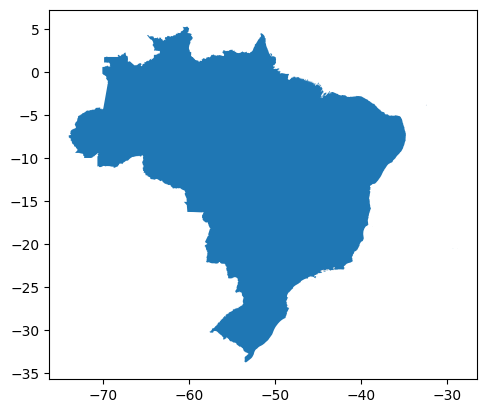

In [ ]:
brasil.plot()

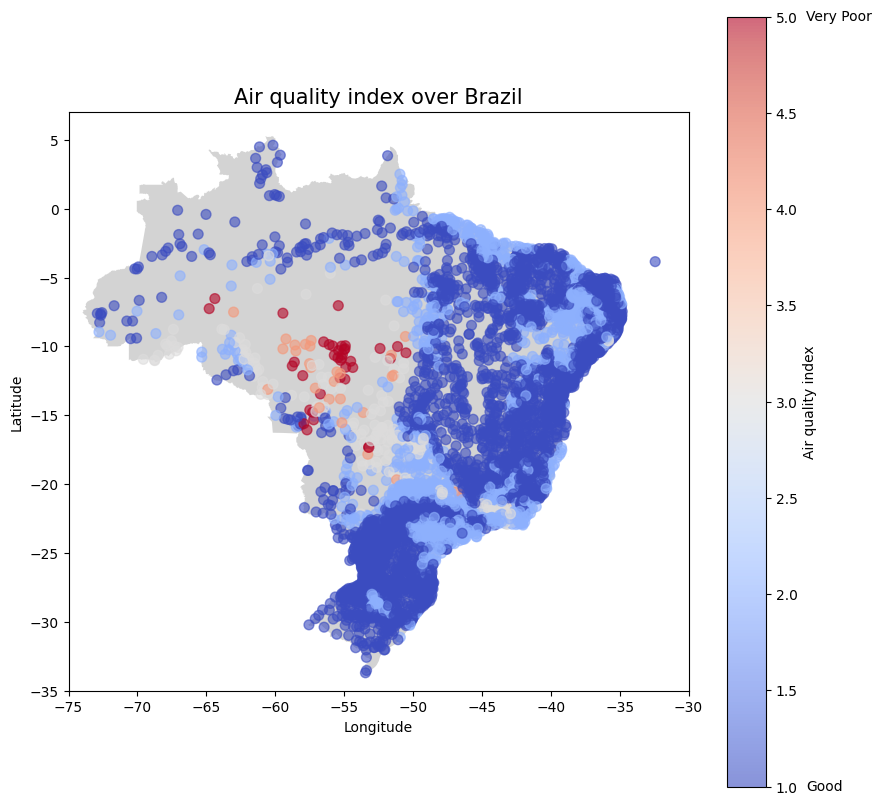

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

brasil.plot(ax=ax, color="lightgrey")


scatter = ax.scatter(
    plot_df['lon_rounded'],
    plot_df['lat_rounded'],
    c=plot_df['aqi'],
    cmap='coolwarm',
    s=50,
    alpha=0.6
)


cbar = plt.colorbar(scatter)
cbar.set_label('Air quality index')

cbar.ax.text(2.05, 0, 'Good', transform=cbar.ax.transAxes, va='center', ha='left', fontsize=10)
cbar.ax.text(2.05, 1, 'Very Poor', transform=cbar.ax.transAxes, va='center', ha='left', fontsize=10)


ax.set_xlim([-75, -30])
ax.set_ylim([-35, 7])

ax.set_title("Air quality index over Brazil", fontsize=15)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()